# Global functions
Define global functions to use across the project.

# New Section

In [ ]:
# Required for plotting maps
!pip install folium

In [ ]:
!pip install datetime
!pip install meteostat
!pip install airportsdata

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import time

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Tho following code is part of a larger example.
Source:https://colab.research.google.com/drive/1aPp-iTGX9-WCahi8vkIxtp08LCRpCrIr?usp=sharing#scrollTo=_a5CpRh3MTkX

In [ ]:
def check_data_balance(series, style="seaborn-pastel"):
  with plt.style.context(style):
    unique = series.value_counts()
    display(unique) #show unique value counts of the target
    plt.pie(unique, explode=[0.05]*len(unique), labels=unique.index, autopct='%1.1f%%'); #plot a pie chart for the target to see if data are balanced

# Goal
Build a linear regression model for flights delay calculation using the Airline On-Time Performance Data data set from the Bureau of Transportation Statistics.
More info here: https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr

# Data information
This project is focused to calculate if a flight will be "on-time" for domestic fligths in the United States and compares the predictive accuracy of probability between different models.

# Attribute information

# Load data

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
 
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
# loading the data
link = 'https://drive.google.com/file/d/1dkppUzxB1uA_H9rfHhwxQ8upxLJTc2is/view?usp=sharing'
 
import pandas as pd
 
# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Flights_2018.csv') 
df_flights_2018 = pd.read_csv('Flights_2018.csv')

In [ ]:
df_flights_2018['OP_CARRIER'].unique()

array(['UA', 'AS', '9E', 'B6', 'EV', 'F9', 'HA', 'MQ', 'NK', 'OH', 'OO',
       'VX', 'WN', 'YV', 'YX', 'AA', 'DL', 'G4'], dtype=object)

In [ ]:
df_flights_2018.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2018,1,12,5,1/12/2018 12:00:00 AM,UA,PIT,DEN,1624,4.0,1803,2.0,NaN,NaN,NaN,NaN,NaN
1,2018,1,12,5,1/12/2018 12:00:00 AM,UA,BWI,DEN,809,-4.0,1018,-30.0,NaN,NaN,NaN,NaN,NaN
2,2018,1,12,5,1/12/2018 12:00:00 AM,UA,DEN,BOI,1128,76.0,1330,66.0,0.0,66.0,0.0,0.0,0.0
3,2018,1,12,5,1/12/2018 12:00:00 AM,UA,ORD,DEN,1950,-3.0,2134,-18.0,NaN,NaN,NaN,NaN,NaN
4,2018,1,12,5,1/12/2018 12:00:00 AM,UA,DEN,SFO,1009,31.0,1208,50.0,0.0,0.0,50.0,0.0,0.0


In [ ]:
df_flights_2018.shape

(7213446, 17)

**How are flight delays calculated?**

Accordingly to the Bureau of Transportation and Statistics, a flight is counted as "on time" if it operated less than 15 minutes later than the scheduled time shown in the carriers' Computerized Reservations Systems (CRS). Arrival performance is based on arrival at the gate. Departure performance is based on departure from the gate.

Source: https://www.bts.gov/explore-topics-and-geography/topics/airline-time-performance-and-causes-flight-delays

In [ ]:
#Determine whether a flight is delayed
df_flights_2018.loc[df_flights_2018['ARR_DELAY'] > 15,'delayed'] = 1
df_flights_2018['delayed'].fillna(0, inplace=True)

0.0    5908254
1.0    1305192
Name: delayed, dtype: int64

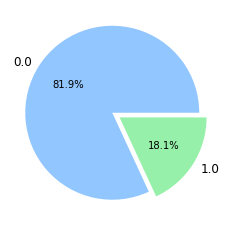

In [ ]:
check_data_balance(df_flights_2018['delayed'])

## Remove non relevant features
There are some features that are only available at time the flight is departed, and others when the flight is completed. This includes the features `DEP_DELAY` and `ARR_DELAY`. In addition to that, accordingly to the BRS, the features `CARRIER_DELAY`, `WEATHER_DELAY`, `NAS_DELAY`, `SECURITY_DELAY`, `LATE_AIRCRAFT_DELAY` are only provided when the arrival time `ARR_DELAY` is greater than 15 minutes. For more information on this regulation please follow the source lunk below.

Source: https://www.bts.gov/explore-topics-and-geography/topics/airline-time-performance-and-causes-flight-delays

In [ ]:
# Drop out of scope features
df_flights_2018.drop('DEP_DELAY', axis=1, inplace=True)
df_flights_2018.drop('ARR_DELAY', axis=1, inplace=True)
df_flights_2018.drop('CARRIER_DELAY', axis=1, inplace=True)
df_flights_2018.drop('WEATHER_DELAY', axis=1, inplace=True)
df_flights_2018.drop('NAS_DELAY', axis=1, inplace=True)
df_flights_2018.drop('SECURITY_DELAY', axis=1, inplace=True)
df_flights_2018.drop('LATE_AIRCRAFT_DELAY', axis=1, inplace=True)

## Remove out-of-scope samples
Taking in count the restrictions in computational demand, the project will be limited to only the first 20 airports with the highgest number of flights.

In [ ]:
selected_airports = df_flights_2018["ORIGIN"].value_counts()[0:20].index.tolist()

In [ ]:
df_flights_2018 = pd.DataFrame(df_flights_2018[(df_flights_2018.ORIGIN.isin(selected_airports)) & df_flights_2018.DEST.isin(selected_airports)],columns=df_flights_2018.columns)

In [ ]:
df_flights_2018['OP_CARRIER'].unique()

array(['UA', 'AS', '9E', 'B6', 'EV', 'F9', 'MQ', 'NK', 'OH', 'OO', 'VX',
       'WN', 'YV', 'YX', 'AA', 'DL'], dtype=object)

In [ ]:
df_flights_2018.shape

(1582624, 11)

## Add Latitude and Longitude coordinates for airports

Load airports information dataset and Add new columns to the data set by look up the the airpot codes.

In [ ]:
def get_latitude_longitude(df_flights,iata_code_feature=[]):
  # loading the data for the airports
  link_Airports = 'https://drive.google.com/file/d/1IwkUq2egSDaxX_cjSr_kMbvCoNcztWt1/view?usp=sharing'
  
  # to get the id part of the file
  id_airports = link_Airports.split("/")[-2]
  
  downloaded_airports = drive.CreateFile({'id':id_airports})
  downloaded_airports.GetContentFile('ICAO_airports.csv') 
  df_airports = pd.read_csv('ICAO_airports.csv')
  countries = ['US']

  for code in iata_code_feature:

    # Merge Pandas DataFrames using left_on and right_on
    df_flights = pd.merge(df_flights, df_airports[df_airports.iso_country.isin(countries)][['local_code','latitude_deg','longitude_deg']], how="left", left_on=code, right_on='local_code')
    
    df_flights.drop('local_code', axis=1, inplace=True)
    print('The following airports were not found in the US list', df_flights[df_flights.latitude_deg.isnull()][code].unique())
    
    # Remove non found airports
    df_flights = df_flights.dropna(subset=["latitude_deg"]) 

    # Rename new columns including iata code feature name
    df_flights.rename(columns={'latitude_deg': 'latitude_deg_' + code,
                              'longitude_deg': 'longitude_deg_' + code},
                      inplace = True)
  
  return df_flights

The following airports are located in unincorporated territory of the United States. They represent 0.63% of the entire dataset. Since the location won't be gatered for these airports we proceed to delete them from the flights table.

In [ ]:
df_flights_2018 = get_latitude_longitude(df_flights_2018, ['ORIGIN','DEST'])

The following airports were not found in the US list []
The following airports were not found in the US list []


In [ ]:
df_flights_2018.sample(5)

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,delayed,latitude_deg_ORIGIN,longitude_deg_ORIGIN,latitude_deg_DEST,longitude_deg_DEST
937534,2018,8,25,6,8/25/2018 12:00:00 AM,UA,ORD,BOS,2135,54,0.0,41.978600,-87.904800,42.364300,-71.005203
950964,2018,8,13,1,8/13/2018 12:00:00 AM,DL,EWR,ATL,1000,1225,1.0,40.692501,-74.168701,33.636700,-84.428101
1248586,2018,10,17,3,10/17/2018 12:00:00 AM,UA,LAS,EWR,1350,2143,1.0,36.080101,-115.152000,40.692501,-74.168701
1172128,2018,9,30,7,9/30/2018 12:00:00 AM,AA,SFO,JFK,1516,1,0.0,37.618999,-122.375000,40.639801,-73.778900
1211264,2018,10,31,3,10/31/2018 12:00:00 AM,DL,LGA,MCO,1415,1658,0.0,40.777199,-73.872597,28.429399,-81.308998


In [ ]:
df_flights_2018.shape

(1582624, 15)

## Add weather information

In [ ]:
from datetime import datetime
from meteostat import Point, Daily
import airportsdata
import time

In [ ]:
airports = airportsdata.load('IATA')

In [ ]:
# Get the list of origin airports in the dataset
list_of_airports = df_flights_2018["ORIGIN"].unique().tolist()

list_of_airports

['ORD',
 'DEN',
 'SFO',
 'LAX',
 'ATL',
 'MCO',
 'DCA',
 'EWR',
 'DFW',
 'PHX',
 'MSP',
 'LGA',
 'SEA',
 'IAH',
 'BOS',
 'LAS',
 'PHL',
 'DTW',
 'CLT',
 'JFK']

In [ ]:
def weather_from_IATA(IATA):
    """
    uses airport data from "airportsdata" to find latitude and longitude
    and pass lat and lon into meteostat, which will return the weather at
    that airport at that time.
    """
    lat, lon = airports[IATA]['lat'], airports[IATA]['lon']

    # Set time period
    start = datetime(2018, 1, 1)
    end = datetime(2018, 12, 31)

    # Create Point for airport
    location = Point(lat, lon)

    # Get daily data for location
    data = Daily(location, start, end)
    weather_time = data.fetch()

    return weather_time

In [ ]:
def edit_datetime(unedited):
    removed_space = (unedited.split(" ", 1)[0])
    datetime_object = datetime.strptime(removed_space, "%m/%d/%Y")
    return datetime_object

In [ ]:
df_flights_2018['FL_DATE'] = df_flights_2018['FL_DATE'].apply(edit_datetime)

In [ ]:
df_flights_2018.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,delayed,latitude_deg_ORIGIN,longitude_deg_ORIGIN,latitude_deg_DEST,longitude_deg_DEST
0,2018,1,12,5,2018-01-12,UA,ORD,DEN,1950,2134,0.0,41.978600,-87.904800,39.861698,-104.672997
1,2018,1,12,5,2018-01-12,UA,DEN,SFO,1009,1208,1.0,39.861698,-104.672997,37.618999,-122.375000
2,2018,1,12,5,2018-01-12,UA,SFO,PHL,1431,2251,1.0,37.618999,-122.375000,39.871899,-75.241096
3,2018,1,12,5,2018-01-12,UA,DEN,SFO,1300,1449,1.0,39.861698,-104.672997,37.618999,-122.375000
4,2018,1,12,5,2018-01-12,UA,DEN,ORD,1246,1615,0.0,39.861698,-104.672997,41.978600,-87.904800


In [ ]:
df_airports_weather_2018 = pd.DataFrame

for i in range(len(list_of_airports)):
    airport_iata = list_of_airports[i]
    #print("Getting weater information for " + airport_iata)
    weather_data = weather_from_IATA(airport_iata)
    weather_data = weather_data.reset_index()
    #print("Information for " + str(weather_data.index.size) + " days found")
    # Handling missing pressure information
    weather_data['pres'] = weather_data['pres'].fillna(weather_data['pres'].mean())
    if i == 0:
      weather_data.loc[:,'IATA_code'] = airport_iata
      df_airports_weather_2018 = weather_data
    else:
      weather_data.loc[:,'IATA_code'] = airport_iata
      df_airports_weather_2018 = df_airports_weather_2018.append(weather_data)

In [ ]:
df_airports_weather_2018.sample(5)

,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,IATA_code
123,2018-05-04,19.5,11.7,25.6,0.0,0.0,290.0,19.1,NaN,1010.9,NaN,MSP
234,2018-08-23,23.1,14.4,31.7,0.0,0.0,281.0,23.0,NaN,1009.9,NaN,DEN
261,2018-09-19,23.8,19.4,28.3,0.0,0.0,25.0,12.2,NaN,1012.0,NaN,LGA
164,2018-06-14,37.8,32.2,42.8,0.0,0.0,280.0,16.9,NaN,1003.1,NaN,PHX
272,2018-09-30,24.0,20.0,27.8,0.0,0.0,93.0,9.7,NaN,1024.4,NaN,CLT


In [ ]:
df_airports_weather_2018.describe()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
count,7300.000000,7300.000000,7300.000000,7300.000000,7261.000000,5958.000000,7300.00000,0.0,7300.000000,369.000000
mean,15.523753,10.859425,20.591836,2.928219,5.110178,189.196039,13.68374,NaN,1017.216832,351.046070
std,10.153312,10.033134,10.810769,8.815620,29.778364,97.061691,6.09882,NaN,6.750806,279.111879
min,-22.400000,-25.500000,-17.100000,0.000000,0.000000,0.000000,0.00000,NaN,991.500000,0.000000
25%,8.100000,3.300000,12.800000,0.000000,0.000000,111.000000,9.40000,NaN,1012.900000,42.000000
50%,16.300000,11.700000,21.700000,0.000000,0.000000,200.000000,12.60000,NaN,1017.100000,354.000000
75%,23.700000,19.400000,29.100000,0.800000,0.000000,268.750000,16.90000,NaN,1021.000000,569.000000
max,40.600000,34.400000,46.700000,148.600000,480.000000,359.000000,61.20000,NaN,1044.100000,900.000000


In [ ]:
print('shape: ' , df_airports_weather_2018.shape)
print("Percentages of missing values per variable: ")
print(df_airports_weather_2018.isnull().mean())

shape:  (7300, 12)
Percentages of missing values per variable: 
time         0.000000
tavg         0.000000
tmin         0.000000
tmax         0.000000
prcp         0.000000
snow         0.005342
wdir         0.183836
wspd         0.000000
wpgt         1.000000
pres         0.000000
tsun         0.949452
IATA_code    0.000000
dtype: float64


### Handle NAN Columns

In the case of the pres feature, it was identified that only 3.43% of the data is missing in the information, and also taking as an assupmtion the pressure for a location won't change to an outlier value, this value will be populated with the median during the weather information gatering.

In [ ]:
# Drop rows for which column is NAN!
for col in ['snow','wdir','wpgt','tsun']:
  df_airports_weather_2018 = df_airports_weather_2018.drop(col, axis=1)

In [ ]:
df_airports_weather_2018.shape

(7300, 8)

In [ ]:
def get_flights_weather(df_flights,df_weather,iata_code_feature=[]):

  for code in iata_code_feature:
    df_weather_code = df_weather.add_suffix('_' + code)
    # Merge Pandas DataFrames using left_on and right_on
    df_flights = pd.merge(df_flights, df_weather_code, how="left", left_on=[code,'FL_DATE'], right_on=['IATA_code_' + code,'time_' + code])
    
    df_flights.drop('IATA_code_' + code, axis=1, inplace=True)
    df_flights.drop('time_' + code, axis=1, inplace=True)
  
  return df_flights

In [ ]:
df_flights_2018 = get_flights_weather(df_flights_2018, df_airports_weather_2018, ['ORIGIN','DEST'])

In [ ]:
df_flights_2018.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,...,tmax_ORIGIN,prcp_ORIGIN,wspd_ORIGIN,pres_ORIGIN,tavg_DEST,tmin_DEST,tmax_DEST,prcp_DEST,wspd_DEST,pres_DEST
0,2018,1,12,5,2018-01-12,UA,ORD,DEN,1950,2134,...,-4.9,0.0,32.0,1021.300000,1.8,-4.3,7.8,0.8,16.6,1019.400000
1,2018,1,12,5,2018-01-12,UA,DEN,SFO,1009,1208,...,7.8,0.8,16.6,1019.400000,11.8,10.0,12.8,0.0,4.3,1016.754017
2,2018,1,12,5,2018-01-12,UA,SFO,PHL,1431,2251,...,12.8,0.0,4.3,1016.754017,15.2,11.7,17.8,36.1,18.4,1011.100000
3,2018,1,12,5,2018-01-12,UA,DEN,SFO,1300,1449,...,7.8,0.8,16.6,1019.400000,11.8,10.0,12.8,0.0,4.3,1016.754017
4,2018,1,12,5,2018-01-12,UA,DEN,ORD,1246,1615,...,7.8,0.8,16.6,1019.400000,-4.8,-9.9,-4.9,0.0,32.0,1021.300000


Removing 'FL_DATE' feature for redundancy as *YEAR*, *MONTH*, *DAY_OF_MONTH*    , *DAY_OF_WEEK*.. unify to describe 'FL_DATE'.. 

In [ ]:
df_flights_2018.drop('FL_DATE', axis=1, inplace=True)

# Data exploration

## Data Structure

In [ ]:
df_flights_2018.shape

(1582624, 26)

There are 7,213,446 instances in the dataset. Notice that the `DEP_DELAY` attribute has 7,096,212 non missing values, the `ARR_DELAY` has 7,076,406, and the attributes `CARRIER_DELAY`, `WEATHER_DELAY`, `NAS_DELAY`, `SECURITY_DELAY`,`LATE_AIRCRAFT_DELAY` have only 1,352,710 instances.

In [ ]:
# Print a concise summary of a DataFrame.
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html
df_flights_2018.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1582624 entries, 0 to 1582623
Data columns (total 26 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   YEAR                  1582624 non-null  int64  
 1   MONTH                 1582624 non-null  int64  
 2   DAY_OF_MONTH          1582624 non-null  int64  
 3   DAY_OF_WEEK           1582624 non-null  int64  
 4   OP_CARRIER            1582624 non-null  object 
 5   ORIGIN                1582624 non-null  object 
 6   DEST                  1582624 non-null  object 
 7   CRS_DEP_TIME          1582624 non-null  int64  
 8   CRS_ARR_TIME          1582624 non-null  int64  
 9   delayed               1582624 non-null  float64
 10  latitude_deg_ORIGIN   1582624 non-null  float64
 11  longitude_deg_ORIGIN  1582624 non-null  float64
 12  latitude_deg_DEST     1582624 non-null  float64
 13  longitude_deg_DEST    1582624 non-null  float64
 14  tavg_ORIGIN           1582624 non-

It is also pssible to determine the dataset contains information from 342 origin airports and the same amount of destination airports.

In [ ]:
print("Origin airports:",df_flights_2018['ORIGIN'].unique().size)
print("Destination airports:",df_flights_2018['DEST'].unique().size)

Origin airports: 20
Destination airports: 20


In [ ]:
df_flights_2018.sample(5)

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,delayed,...,tmax_ORIGIN,prcp_ORIGIN,wspd_ORIGIN,pres_ORIGIN,tavg_DEST,tmin_DEST,tmax_DEST,prcp_DEST,wspd_DEST,pres_DEST
728970,2018,6,4,1,B6,MCO,LGA,1718,2000,0.0,...,33.9,0.0,18.9,1013.9,16.9,11.7,23.9,2.8,12.2,1008.1
1026525,2018,8,5,7,NK,MCO,ATL,2225,2354,0.0,...,33.3,0.0,12.6,1021.4,26.8,21.7,32.8,0.0,3.0,1022.1
1529329,2018,12,27,4,DL,ATL,DFW,2130,2300,1.0,...,12.2,21.1,15.6,1023.7,13.5,4.4,16.7,6.1,22.3,1006.9
1156893,2018,9,27,4,MQ,LGA,PHL,2021,2142,0.0,...,25.0,0.3,12.8,1018.5,20.5,16.1,22.2,0.5,15.8,1018.5
368101,2018,3,14,3,AS,SEA,MCO,2120,556,0.0,...,11.7,0.8,16.2,1012.1,14.6,10.0,21.1,0.0,15.6,1019.4


In [ ]:
df_flights_2018.describe()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,CRS_ARR_TIME,delayed,latitude_deg_ORIGIN,longitude_deg_ORIGIN,latitude_deg_DEST,...,tmax_ORIGIN,prcp_ORIGIN,wspd_ORIGIN,pres_ORIGIN,tavg_DEST,tmin_DEST,tmax_DEST,prcp_DEST,wspd_DEST,pres_DEST
count,1582624.0,1.582624e+06,1.582624e+06,1.582624e+06,1.582624e+06,1.582624e+06,1.582624e+06,1.582624e+06,1.582624e+06,1.582624e+06,...,1.582624e+06,1.582624e+06,1.582624e+06,1.582624e+06,1.582624e+06,1.582624e+06,1.582624e+06,1.582624e+06,1.582624e+06,1.582624e+06
mean,2018.0,6.545259e+00,1.575546e+01,3.917285e+00,1.316635e+03,1.492928e+03,1.976016e-01,3.789868e+01,-9.331275e+01,3.789672e+01,...,2.086243e+01,2.849033e+00,1.365861e+01,1.017022e+03,1.576641e+01,1.110299e+01,2.086395e+01,2.848466e+00,1.365648e+01,1.017024e+03
std,0.0,3.388351e+00,8.762033e+00,1.990687e+00,5.002241e+02,5.346117e+02,3.981900e-01,4.739256e+00,1.736426e+01,4.739553e+00,...,1.056221e+01,8.812196e+00,6.078236e+00,6.600737e+00,9.913820e+00,9.822475e+00,1.056237e+01,8.810997e+00,6.077853e+00,6.600193e+00
min,2018.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,2.842940e+01,-1.223750e+02,2.842940e+01,...,-1.710000e+01,0.000000e+00,0.000000e+00,9.915000e+02,-2.240000e+01,-2.550000e+01,-1.710000e+01,0.000000e+00,0.000000e+00,9.915000e+02
25%,2018.0,4.000000e+00,8.000000e+00,2.000000e+00,9.000000e+02,1.105000e+03,0.000000e+00,3.363670e+01,-1.120120e+02,3.363670e+01,...,1.330000e+01,0.000000e+00,9.400000e+00,1.012800e+03,8.700000e+00,3.900000e+00,1.330000e+01,0.000000e+00,9.400000e+00,1.012800e+03
50%,2018.0,7.000000e+00,1.600000e+01,4.000000e+00,1.308000e+03,1.528000e+03,0.000000e+00,3.885210e+01,-8.790480e+01,3.885210e+01,...,2.170000e+01,0.000000e+00,1.260000e+01,1.016900e+03,1.660000e+01,1.220000e+01,2.170000e+01,0.000000e+00,1.260000e+01,1.016900e+03
75%,2018.0,9.000000e+00,2.300000e+01,6.000000e+00,1.730000e+03,1.926000e+03,0.000000e+00,4.197860e+01,-7.703770e+01,4.197860e+01,...,2.890000e+01,8.000000e-01,1.690000e+01,1.020700e+03,2.360000e+01,1.890000e+01,2.890000e+01,8.000000e-01,1.690000e+01,1.020700e+03
max,2018.0,1.200000e+01,3.100000e+01,7.000000e+00,2.359000e+03,2.400000e+03,1.000000e+00,4.744900e+01,-7.100520e+01,4.744900e+01,...,4.670000e+01,1.486000e+02,6.120000e+01,1.044100e+03,4.060000e+01,3.440000e+01,4.670000e+01,1.486000e+02,6.120000e+01,1.044100e+03


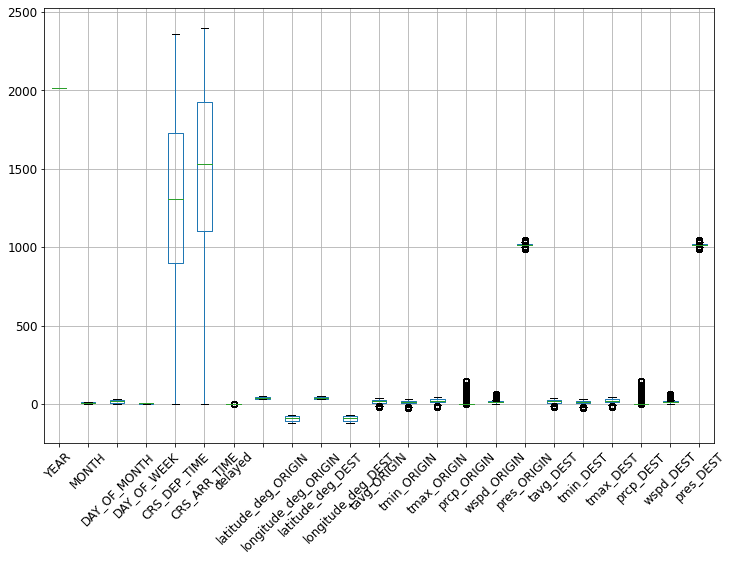

In [ ]:
df_flights_2018.boxplot(figsize=(12,8),rot=45)
plt.show()

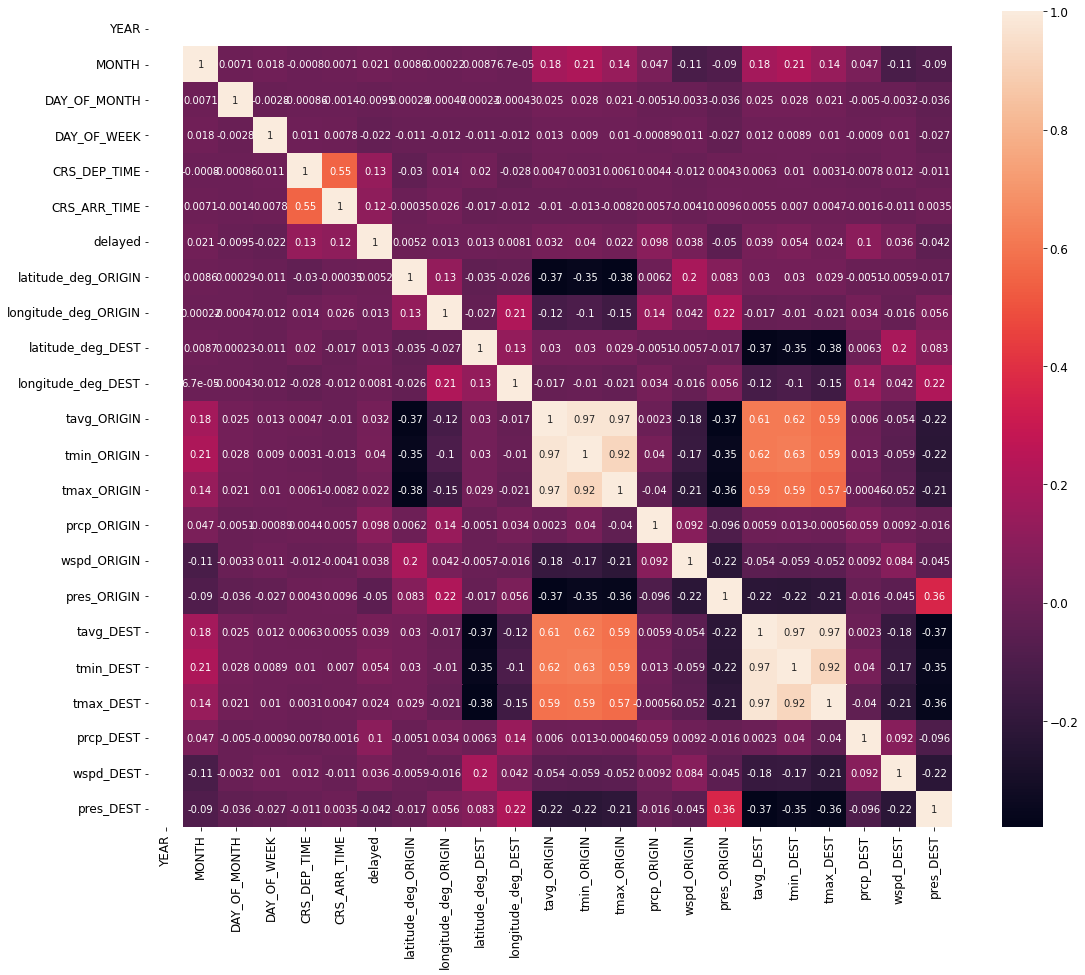

In [ ]:
#Correlation map
# View correlation
# In order to view the correlation in your features you can call the corr function
# It shows the correlation between every pair of features
corrMatrix = df_flights_2018.corr()

fig, ax = plt.subplots(figsize=(18,15))
sns.heatmap(corrMatrix, annot=True,annot_kws={"size": 10})
plt.show()

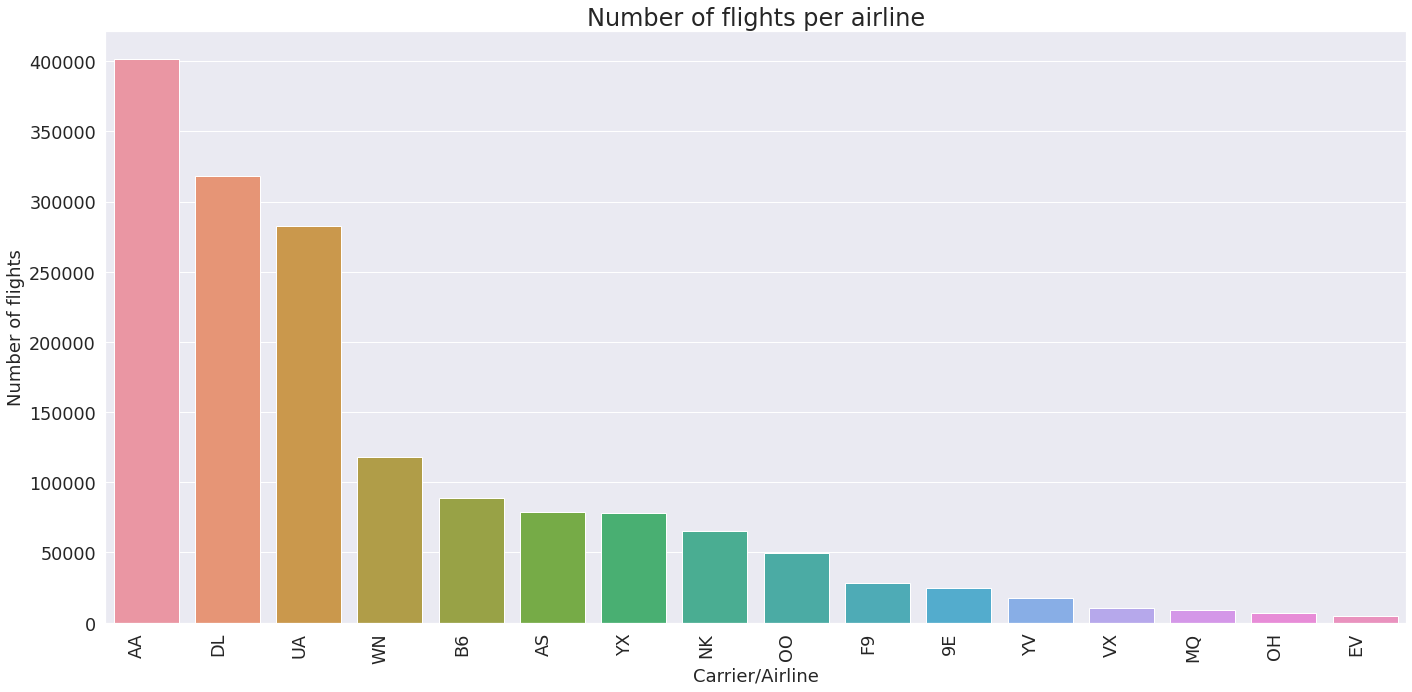

In [ ]:
#Number of flights per airline

plt.figure(figsize=(20, 10))
sns.set(font_scale=1.6)
axis = sns.countplot(x=df_flights_2018['OP_CARRIER'], data=df_flights_2018, order=df_flights_2018['OP_CARRIER'].value_counts().iloc[0:18].index, orient="v")
axis.set_xticklabels(axis.get_xticklabels(), rotation=90, ha='right')
plt.title('Number of flights per airline', fontsize=24)
plt.xlabel('Carrier/Airline', fontsize=18)
plt.ylabel('Number of flights', fontsize=18)
plt.tight_layout()
plt.show()

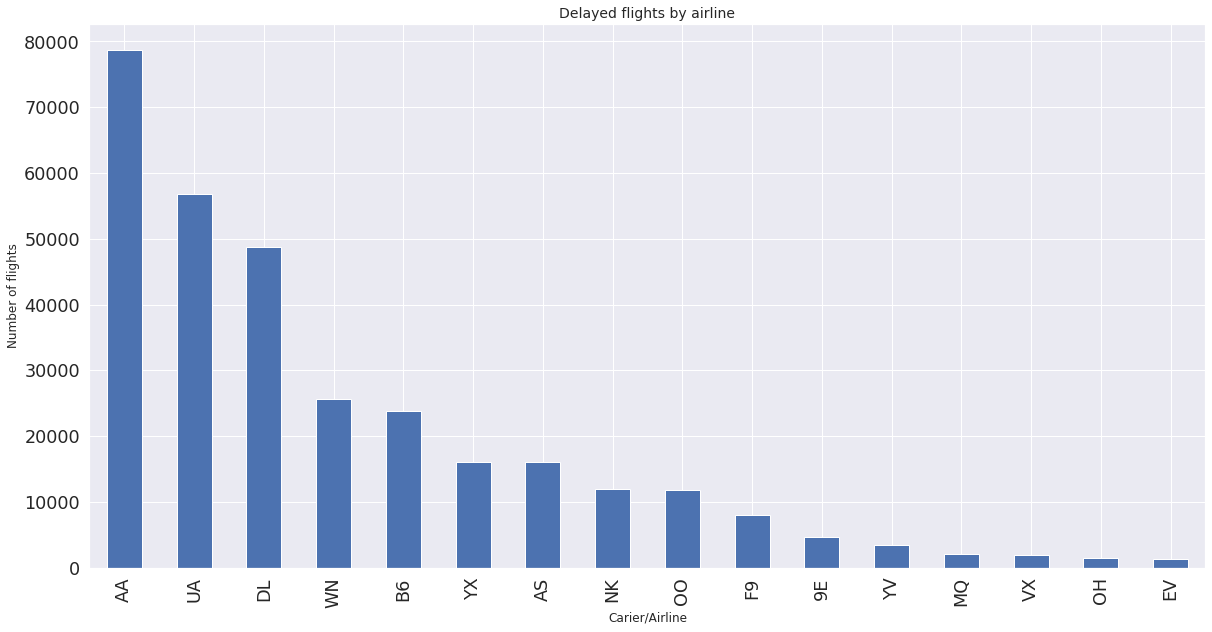

In [ ]:
#Number of delayed flights by airline

plt.figure(figsize=(20, 10))
df_flights_2018.groupby('OP_CARRIER').delayed.sum().sort_values(ascending=False).plot.bar()
plt.title('Delayed flights by airline', fontsize=14)
plt.xlabel('Carier/Airline', fontsize=12)
plt.ylabel('Number of flights', fontsize=12)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
plt.show()

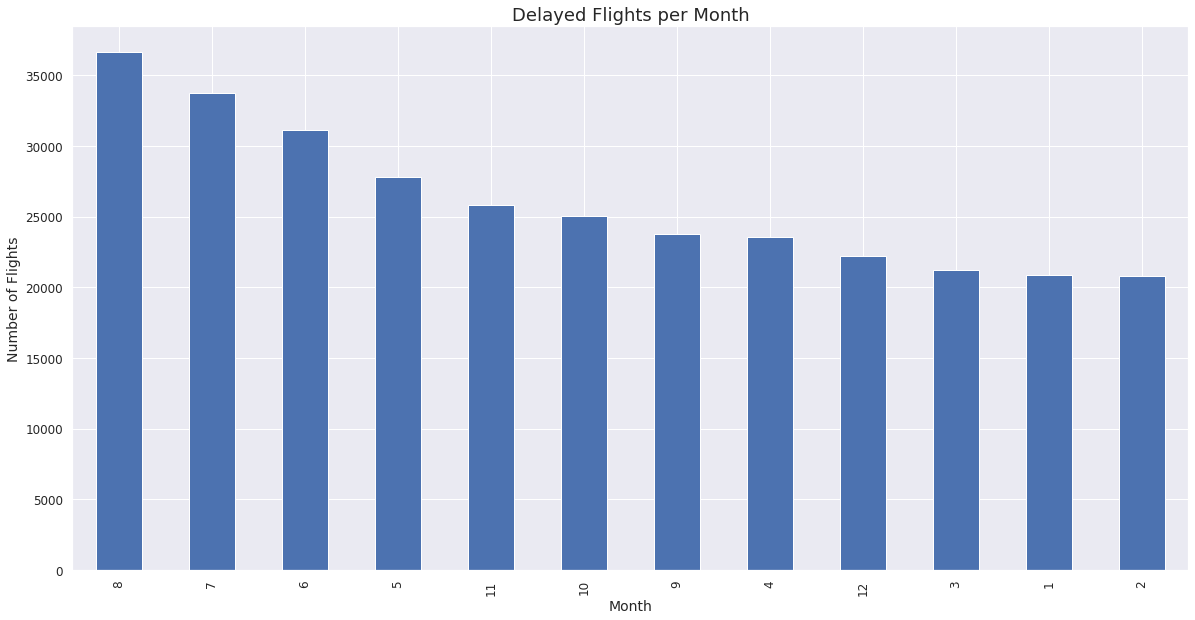

In [ ]:
#delayed flights per month
plt.figure(figsize=(20, 10))
df_flights_2018.groupby('MONTH').delayed.sum().sort_values(ascending=False).plot.bar()
plt.title('Delayed Flights per Month', fontsize=18)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Flights', fontsize=14)
plt.show()

In [ ]:
df_flights_2018_toplot = df_flights_2018.groupby(['latitude_deg_ORIGIN','longitude_deg_ORIGIN'])['delayed'].agg(['sum','count']).reset_index()
df_flights_2018_toplot['% Delayed'] = 100 * df_flights_2018_toplot['sum']  / df_flights_2018_toplot['count']
df_flights_2018_toplot.sample(5)

,latitude_deg_ORIGIN,longitude_deg_ORIGIN,sum,count,% Delayed
5,33.942501,-118.407997,20138.0,116974,17.215792
0,28.429399,-81.308998,14728.0,71638,20.558921
17,42.364300,-71.005203,18979.0,89567,21.189724
12,40.639801,-73.778900,11926.0,61671,19.338101
15,41.978600,-87.904800,30341.0,125272,24.220097


In [ ]:
import folium
from folium.plugins import HeatMap

folium_map = folium.Map(location = [38.5000, -98.0000],
                        zoom_start = 4)

flights_zip = zip(df_flights_2018_toplot['latitude_deg_ORIGIN'], df_flights_2018_toplot['longitude_deg_ORIGIN'], df_flights_2018_toplot['% Delayed'])
list_of_fligths_zip = list(flights_zip)

hm_layer = HeatMap(list_of_fligths_zip,
                  min_opacity=0.7,
                  radius=8,
                  blur=8,
                  )

folium_map.add_child(hm_layer)
folium_map

## Histograms

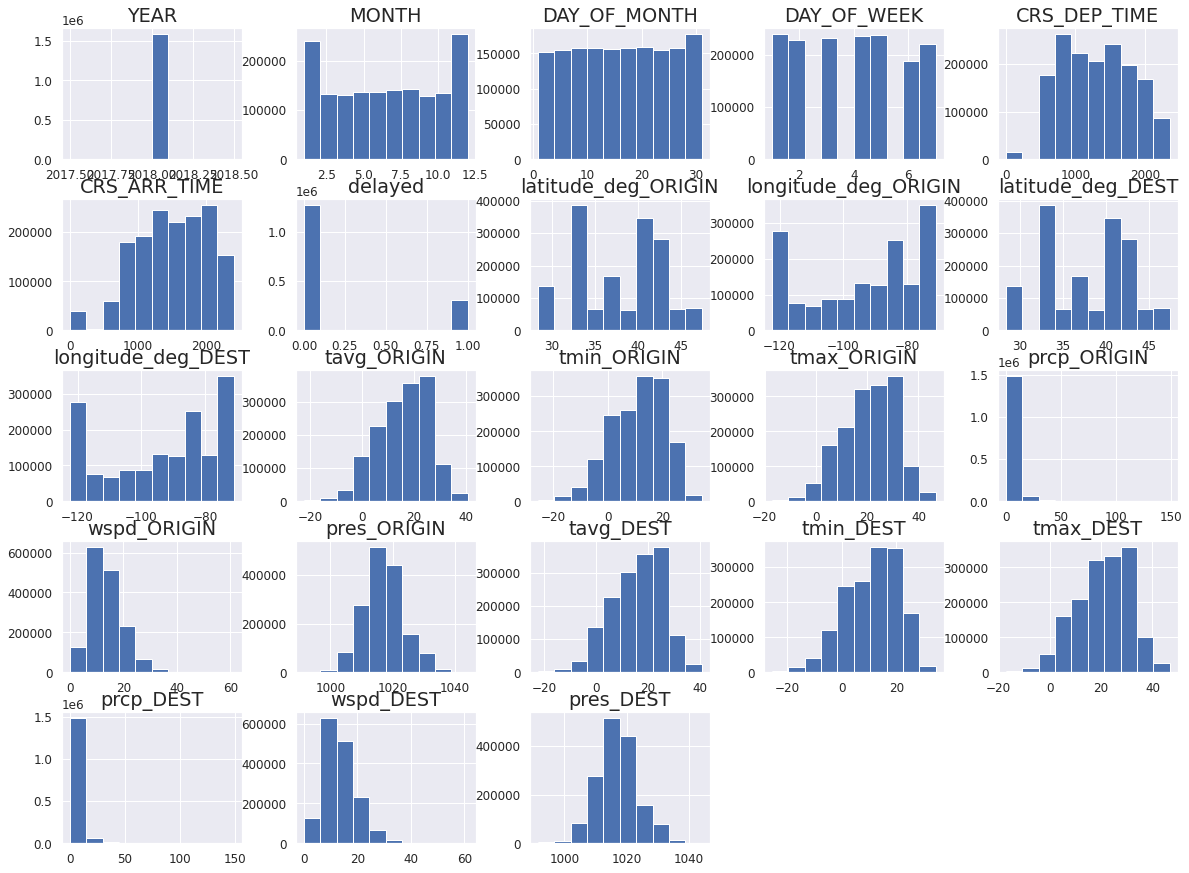

In [ ]:
df_flights_2018.hist(figsize=(20,15))
plt.show()

## Pair plot

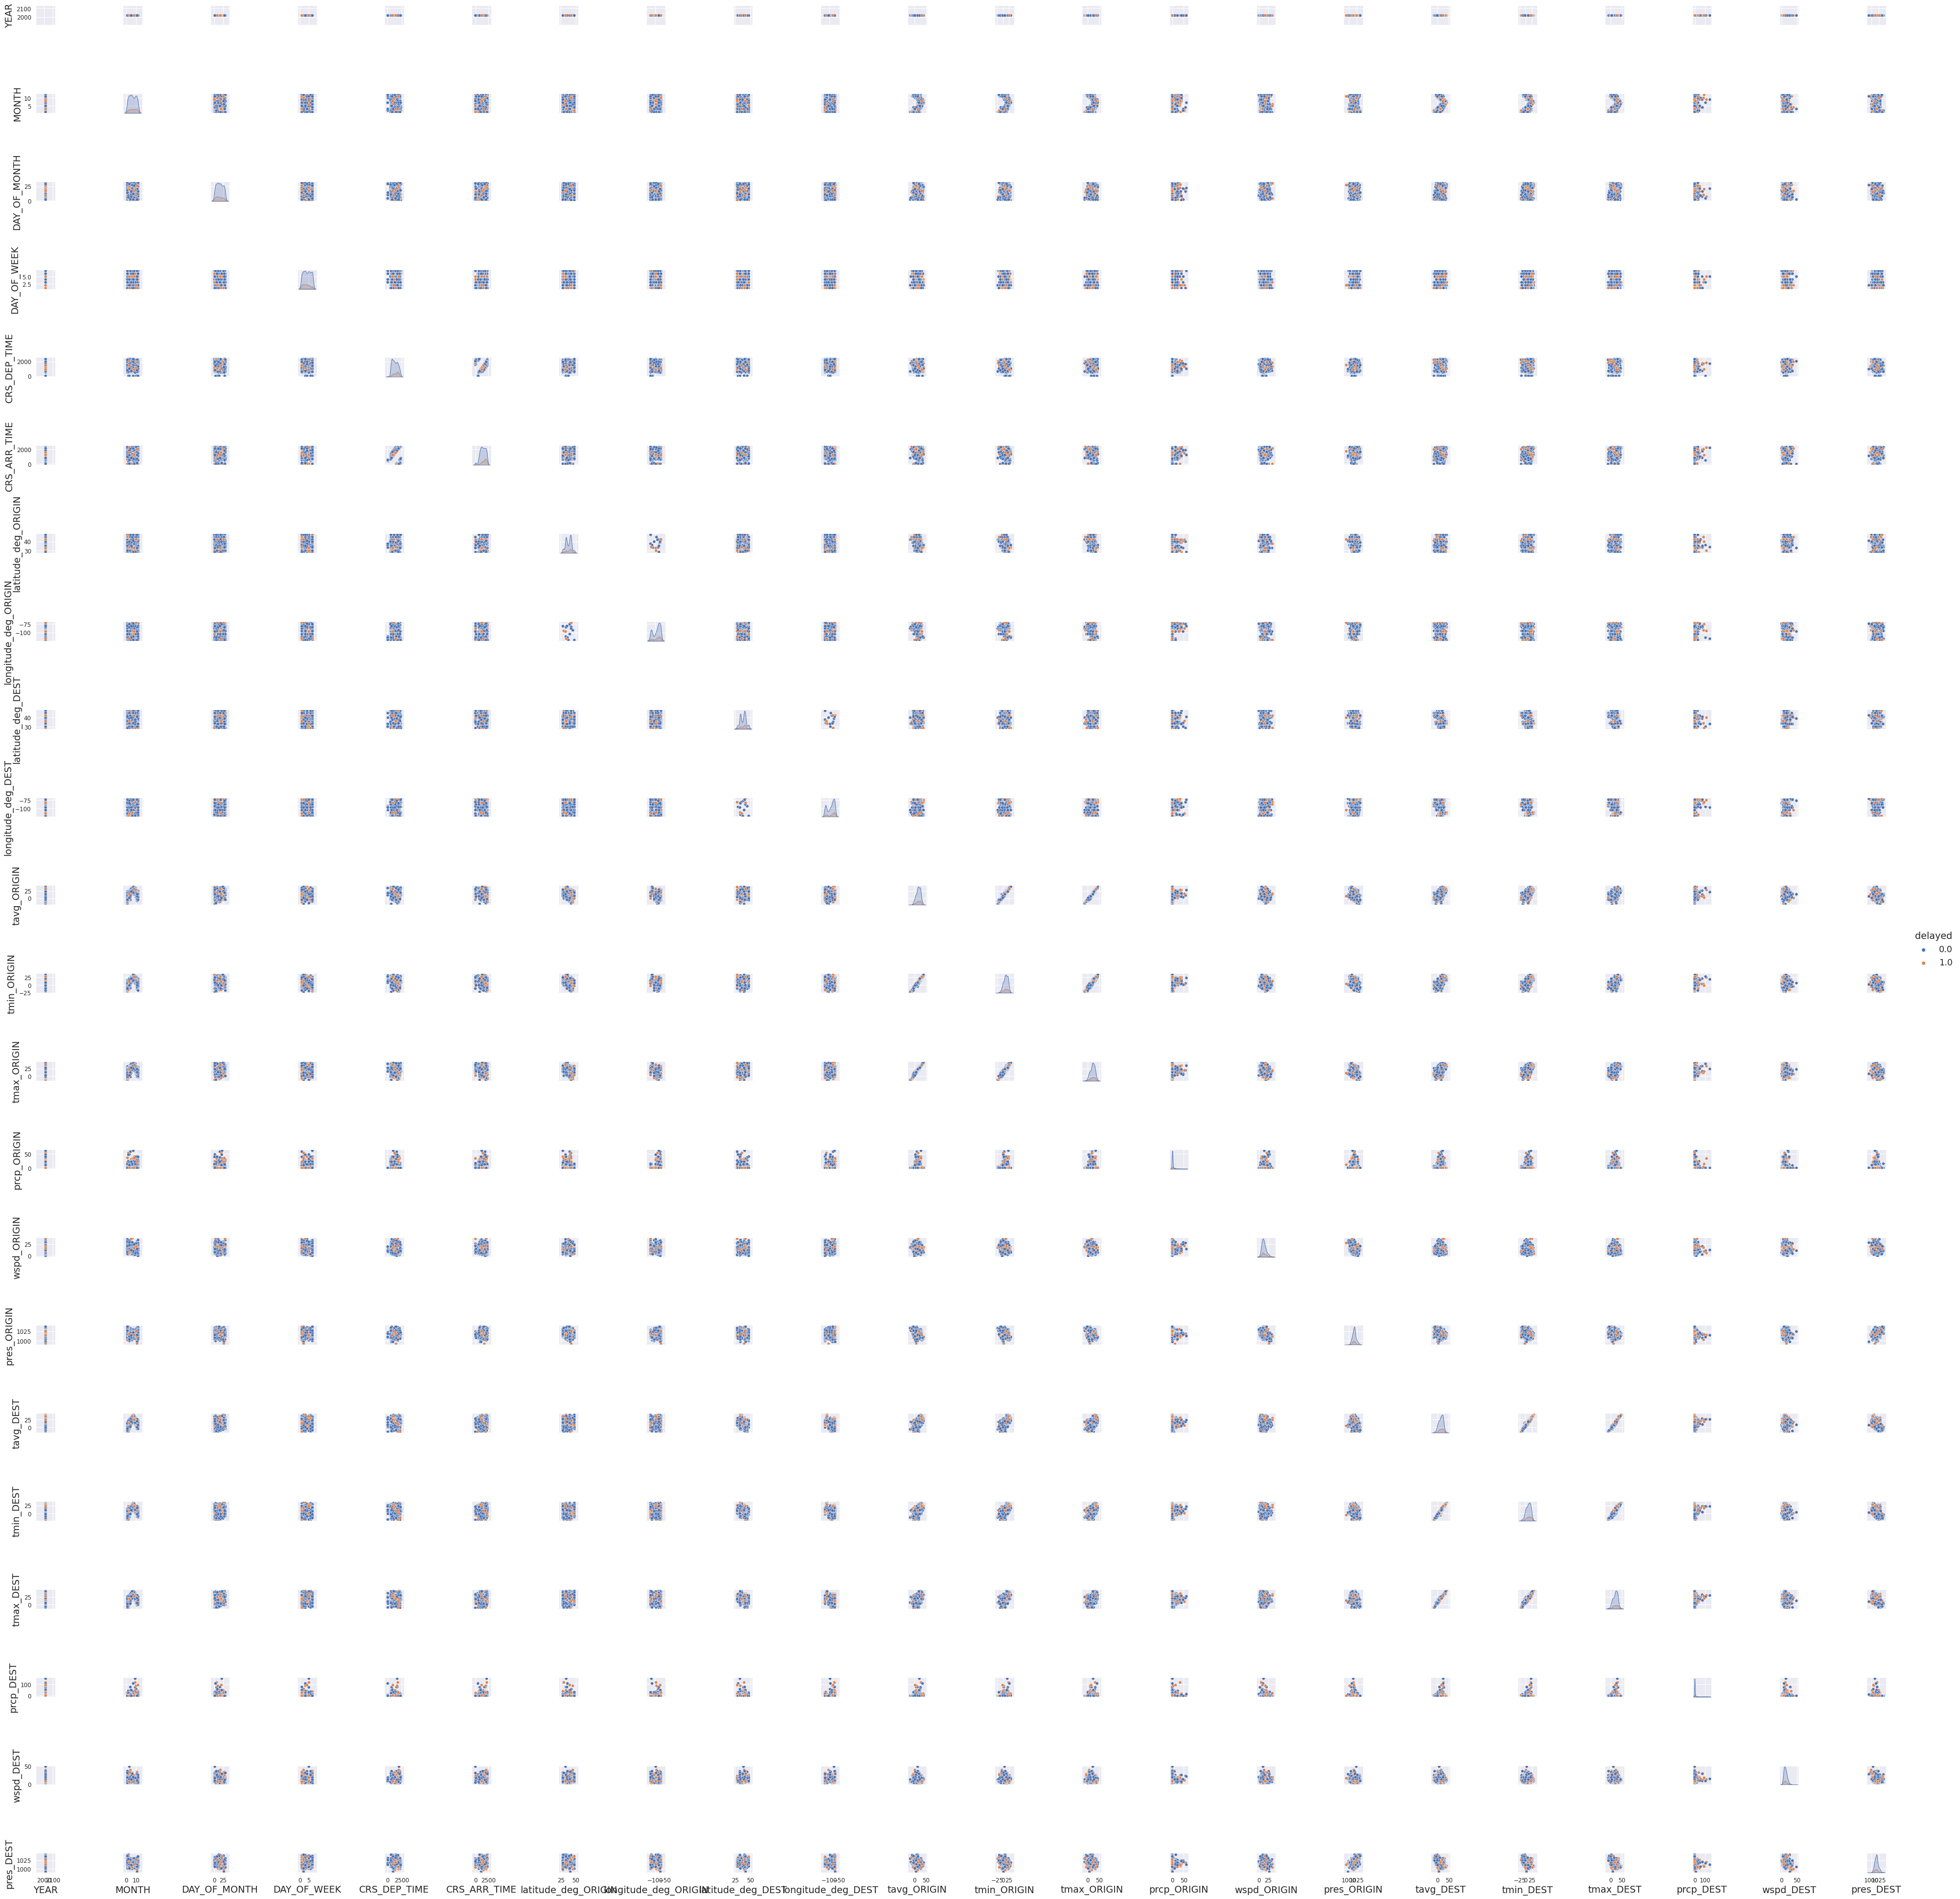

In [ ]:
sns.pairplot(df_flights_2018.sample(1000, random_state=10086), hue="delayed")

In [ ]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = pd.concat([X, y], axis=1)

y_name = 'delayed'
features_names = [f'feature_{i}' for i in range(1, X.shape[1]+1)]  
column_names = features_names + [y_name]
data.columns = column_names

plot_size=7
num_plots_x=5   # No. of plots in every row
num_plots_y = math.ceil(len(features_names)/num_plots_x)   # No. of plots in y direction

'''
for i in range(num_plots_y):
    start = i * num_plots_x
    end = start + num_plots_x
    sns.pairplot(x_vars=features_names[start:end], y_vars=y_name, data=data)
'''

g = sns.FacetGrid(pd.DataFrame(features_names), col=0, col_wrap=4, sharex=False)
for ax, x_var in zip(g.axes, features_names):
    sns.scatterplot(data=data, x=x_var, y=y_name, ax=ax)
g.tight_layout()

# Machine Learning

## Prepare the Data for Machine Learning Algorithms

### Data Cleaning

Save preprocessed data to a file

In [ ]:
#Mount your Google drive so you can read them easily
from google.colab import drive
drive.mount('/content/gdrive')
df_flights_2018.to_csv('/content/gdrive/MyDrive/U of T/df_flights_2018_processed.csv')

Mounted at /content/gdrive


In [ ]:
# loading the data
link = 'https://drive.google.com/file/d/1DfzhaG93iELQYL3Aeg7lWuG05zrI2G1n/view?usp=sharing'
 
import pandas as pd
 
# to get the id part of the file
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('df_flights_2018_processed.csv') 
df_flights_2018 = pd.read_csv('df_flights_2018_processed.csv')
df_flights_2018.drop(['Unnamed: 0'],'columns',inplace=True) # Drop index column saved in the previous step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Check for missing data

In [ ]:
print('shape: ' , df_flights_2018.shape)
print("Percentages of missing values per variable: ")
print(df_flights_2018.isnull().mean())

shape:  (1582624, 27)
Percentages of missing values per variable: 
YEAR                    0.0
MONTH                   0.0
DAY_OF_MONTH            0.0
DAY_OF_WEEK             0.0
FL_DATE                 0.0
OP_CARRIER              0.0
ORIGIN                  0.0
DEST                    0.0
CRS_DEP_TIME            0.0
CRS_ARR_TIME            0.0
delayed                 0.0
latitude_deg_ORIGIN     0.0
longitude_deg_ORIGIN    0.0
latitude_deg_DEST       0.0
longitude_deg_DEST      0.0
tavg_ORIGIN             0.0
tmin_ORIGIN             0.0
tmax_ORIGIN             0.0
prcp_ORIGIN             0.0
wspd_ORIGIN             0.0
pres_ORIGIN             0.0
tavg_DEST               0.0
tmin_DEST               0.0
tmax_DEST               0.0
prcp_DEST               0.0
wspd_DEST               0.0
pres_DEST               0.0
dtype: float64


In [ ]:
df_flights_2018 = df_flights_2018.sample(frac=1).reset_index(drop=True)
df_flights_2018.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,...,tmax_ORIGIN,prcp_ORIGIN,wspd_ORIGIN,pres_ORIGIN,tavg_DEST,tmin_DEST,tmax_DEST,prcp_DEST,wspd_DEST,pres_DEST
0,2018,11,14,3,2018-11-14,DL,LAS,JFK,2303,700,...,20.0,0.0,6.1,1026.9,4.5,0.0,6.7,0.0,27.4,1029.1
1,2018,7,31,2,2018-07-31,WN,PHX,EWR,1025,1825,...,41.7,0.0,11.9,1009.5,23.4,19.4,27.8,0.0,11.9,1019.7
2,2018,7,1,7,2018-07-01,DL,PHL,ATL,1806,2051,...,35.0,0.0,11.5,1017.0,25.9,22.8,29.4,1.5,7.6,1016.4
3,2018,6,21,4,2018-06-21,WN,ATL,DCA,2025,2215,...,31.1,1.1,7.5,1011.3,25.4,22.2,30.0,0.0,10.8,1008.4
4,2018,7,13,5,2018-07-13,UA,EWR,IAH,605,831,...,29.4,0.0,11.5,1022.8,28.6,23.9,35.0,0.0,7.6,1018.0


## Choose X and y

In [ ]:
# Drop out of scope features
df_flights_2018.drop('YEAR', axis=1, inplace=True)
df_flights_2018.drop('FL_DATE', axis=1, inplace=True)

In [ ]:
TARGET = "delayed"
columns_predictors = [col for col in df_flights_2018.columns if col not in [TARGET]]
columns_categorical = ['OP_CARRIER','ORIGIN','DEST']
columns_numerical = [col for col in columns_predictors if col not in columns_categorical]
print(f"TARGET: {TARGET}")
print(f"columns_predictors: {columns_predictors}")
print(f"columns_categorical: {columns_categorical}")
print(f"columns_numerical: {columns_numerical}")

TARGET: delayed
columns_predictors: ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'latitude_deg_ORIGIN', 'longitude_deg_ORIGIN', 'latitude_deg_DEST', 'longitude_deg_DEST', 'tavg_ORIGIN', 'tmin_ORIGIN', 'tmax_ORIGIN', 'prcp_ORIGIN', 'wspd_ORIGIN', 'pres_ORIGIN', 'tavg_DEST', 'tmin_DEST', 'tmax_DEST', 'prcp_DEST', 'wspd_DEST', 'pres_DEST']
columns_categorical: ['OP_CARRIER', 'ORIGIN', 'DEST']
columns_numerical: ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'latitude_deg_ORIGIN', 'longitude_deg_ORIGIN', 'latitude_deg_DEST', 'longitude_deg_DEST', 'tavg_ORIGIN', 'tmin_ORIGIN', 'tmax_ORIGIN', 'prcp_ORIGIN', 'wspd_ORIGIN', 'pres_ORIGIN', 'tavg_DEST', 'tmin_DEST', 'tmax_DEST', 'prcp_DEST', 'wspd_DEST', 'pres_DEST']


## Train-test split

In [ ]:
X = df_flights_2018[columns_predictors]
y = df_flights_2018[TARGET]
display(X)
display(y)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,latitude_deg_ORIGIN,longitude_deg_ORIGIN,...,tmax_ORIGIN,prcp_ORIGIN,wspd_ORIGIN,pres_ORIGIN,tavg_DEST,tmin_DEST,tmax_DEST,prcp_DEST,wspd_DEST,pres_DEST
0,11,14,3,DL,LAS,JFK,2303,700,36.080101,-115.152000,...,20.0,0.0,6.1,1026.9,4.5,0.0,6.7,0.0,27.4,1029.1
1,7,31,2,WN,PHX,EWR,1025,1825,33.434299,-112.012001,...,41.7,0.0,11.9,1009.5,23.4,19.4,27.8,0.0,11.9,1019.7
2,7,1,7,DL,PHL,ATL,1806,2051,39.871899,-75.241096,...,35.0,0.0,11.5,1017.0,25.9,22.8,29.4,1.5,7.6,1016.4
3,6,21,4,WN,ATL,DCA,2025,2215,33.636700,-84.428101,...,31.1,1.1,7.5,1011.3,25.4,22.2,30.0,0.0,10.8,1008.4
4,7,13,5,UA,EWR,IAH,605,831,40.692501,-74.168701,...,29.4,0.0,11.5,1022.8,28.6,23.9,35.0,0.0,7.6,1018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582619,4,1,7,UA,LAS,EWR,600,1347,36.080101,-115.152000,...,30.0,0.0,8.6,1007.0,10.2,6.7,15.0,0.0,9.5,1016.2
1582620,8,27,1,F9,PHX,ORD,1713,2259,33.434299,-112.012001,...,40.6,0.0,13.3,1007.1,29.7,25.6,33.9,0.0,25.9,1011.5
1582621,6,9,6,9E,LGA,CLT,1600,1814,40.777199,-73.872597,...,28.9,0.0,10.4,1018.8,26.6,19.4,32.2,1.3,5.0,1018.6
1582622,3,19,1,AA,SEA,LAX,550,851,47.449001,-122.308998,...,12.8,0.0,6.8,1024.2,14.4,10.0,21.1,0.0,10.8,1017.9


0          0.0
1          0.0
2          0.0
3          1.0
4          0.0
          ... 
1582619    0.0
1582620    0.0
1582621    1.0
1582622    0.0
1582623    1.0
Name: delayed, Length: 1582624, dtype: float64

Check the balance in the data in the entire dataset.

0.0    1269895
1.0     312729
Name: delayed, dtype: int64

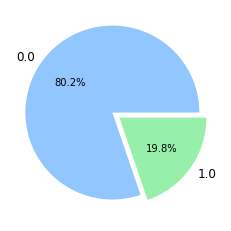

In [ ]:
check_data_balance(y)

### Split Dataset

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (1266099, 24)
X_test.shape: (316525, 24)
y_train.shape: (1266099,)
y_test.shape: (316525,)


Check the balance in the training and testing dataset.

0.0    1015825
1.0     250274
Name: delayed, dtype: int64

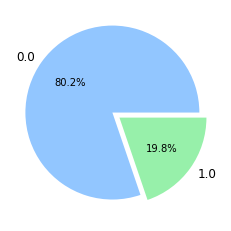

In [ ]:
check_data_balance(y_train)

0.0    254070
1.0     62455
Name: delayed, dtype: int64

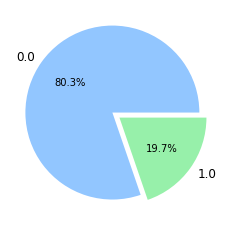

In [ ]:
check_data_balance(y_test)

## Preprocessign the datasets
Some columns like `YEAR`, `MONTH`, `DAY_OF_MONTH`, `DAY_OF_WEEK`, `OP_CARRIER`, `ORIGIN`, `DEST` are considered categorical values and needs to be changed applying onehot encoding.

The correct way to do it is to fit the pipeline on X_train once, and then use the fitted pipeline to transform both X_train and X_test. 

NOTE: <font color="red">Do not fit the pipeline on X_test because you will leak information about the test set!!!!</font>

Reference: https://colab.research.google.com/drive/1aPp-iTGX9-WCahi8vkIxtp08LCRpCrIr?usp=sharing#scrollTo=OdAFWt7Zev-v

### Preprocessing with pipelines

In [ ]:
from sklearn.pipeline import Pipeline #each pipeline can have multiple steps
from sklearn.compose import ColumnTransformer #for selecting specific columns and transforming them with individual pipelines
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder #specific transformations we want to use in our pipelines
from sklearn.feature_selection import VarianceThreshold

pipeline_categorical = Pipeline([
  ('onehot', OneHotEncoder()),
])

pipeline_numerical = Pipeline([
  ('scaler', MinMaxScaler(feature_range=(0,1))),
])

pipeline_full = ColumnTransformer([
  ("categorical", pipeline_categorical, columns_categorical),
  ("numerical", pipeline_numerical, columns_numerical),
])

In [ ]:
X_train[columns_categorical]

,OP_CARRIER,ORIGIN,DEST
1448412,UA,ORD,SFO
1122853,WN,BOS,DEN
407147,WN,LGA,DEN
315327,DL,MSP,CLT
591624,AA,MSP,CLT
...,...,...,...
629203,DL,CLT,MSP
238384,9E,LGA,CLT
413899,NK,LAX,DEN
191812,DL,PHX,MSP


In [ ]:
pipeline_categorical.fit_transform(X_train[columns_categorical]).toarray().shape

(1266099, 56)

In [ ]:
X_train.shape

(1266099, 23)

In [ ]:
# transforming our train and test data for training
pipeline_full.fit(X_train, y_train)
X_train_transformed = pipeline_full.transform(X_train)
X_test_transformed = pipeline_full.transform(X_test)
print(f"X_train_transformed.shape: {X_train_transformed.shape}")
print(f"X_test_transformed.shape: {X_test_transformed.shape}")

X_train_transformed.shape: (1266099, 77)
X_test_transformed.shape: (316525, 77)


  **Dimensionality Reduction Using PCA**

In [ ]:
from sklearn.decomposition import PCA


pca = PCA(n_components = 0.95)
X_train_transformed_reduced = pca.fit_transform(X_train_transformed)
X_test_transformed_reduced = pca.transform(X_test_transformed)

print(f"X_train_transformed.shape: {X_train_transformed.shape}")
print(f"X_train_reduced.shape: {X_train_transformed_reduced.shape}")
print(f"X_train_transformed.shape: {X_test_transformed.shape}")
print(f"X_train_reduced.shape: {X_test_transformed_reduced.shape}")

X_train_transformed.shape: (1266099, 77)
X_train_reduced.shape: (1266099, 50)
X_train_transformed.shape: (316525, 77)
X_train_reduced.shape: (316525, 50)


In [ ]:
train_transformed_col = pd.DataFrame(X_train_transformed).columns
train_reduced_col = pd.DataFrame(X_train_transformed_reduced).columns

a = np.intersect1d(train_transformed_col, train_reduced_col)
print ("Common Columns:",a)



Common Columns: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


## Imports

In [ ]:
import time

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
def summarize_classification(y_test, y_pred):
  acc = accuracy_score(y_test, y_pred, normalize=True) # When you pass normalize eq True, you obtain the accuracy in terms of a fraction
  num_acc = accuracy_score(y_test, y_pred, normalize=False) # And then normalize eq False, you get the number of accurately predicted labels

  prec = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  print('Test data count: ', len(y_test))
  print('accuracy_count: ', num_acc)
  print('accuracy_score: ', acc)
  print('precision_score: ', prec)
  print('recall_score: ', recall)
  print()

## Model 1: Logisitc Regression

In [ ]:
classifier_logistic = LogisticRegression(solver='liblinear', max_iter=100)

parameters = {"C":np.logspace(-3,3,7), 
              "penalty":["l2"]}

print("Optimizing logisitc regression")
start = time.perf_counter()
grid_search = GridSearchCV(classifier_logistic, parameters, cv=3, return_train_score=True)
grid_search.fit(X_train_transformed_reduced, y_train)

grid_search.best_params_

end = time.perf_counter()

print('Total time it took to complete optimizing the model in minutes:' , round((end- start)/60,3))

Optimizing logisitc regression
Total time it took to complete optimizing the model in minutes: 3.257


In [ ]:
for i in range(7):
  print('Parameters: ', grid_search.cv_results_['params'][i])
  print('Mean Test Score: ', grid_search.cv_results_['mean_test_score'][i])
  print('Rank: ', grid_search.cv_results_['rank_test_score'][i])

Parameters:  {'C': 0.001, 'penalty': 'l2'}
Mean Test Score:  0.8023977587850556
Rank:  7
Parameters:  {'C': 0.01, 'penalty': 'l2'}
Mean Test Score:  0.8024254027528653
Rank:  1
Parameters:  {'C': 0.1, 'penalty': 'l2'}
Mean Test Score:  0.802420663786955
Rank:  2
Parameters:  {'C': 1.0, 'penalty': 'l2'}
Mean Test Score:  0.802418294304
Rank:  3
Parameters:  {'C': 10.0, 'penalty': 'l2'}
Mean Test Score:  0.8024151349933931
Rank:  4
Parameters:  {'C': 100.0, 'penalty': 'l2'}
Mean Test Score:  0.8024151349933931
Rank:  4
Parameters:  {'C': 1000.0, 'penalty': 'l2'}
Mean Test Score:  0.8024151349933931
Rank:  4


In [ ]:
grid_search.best_params_

{'C': 0.01, 'penalty': 'l2'}

In [ ]:
logistic_model = LogisticRegression( \
                                    C= grid_search.best_params_['C'], 
                                    penalty=grid_search.best_params_['penalty'],
                                    max_iter=1000).fit(X_train_transformed, y_train)

In [ ]:
y_pred = logistic_model.predict(X_test_transformed)

In [ ]:
summarize_classification(y_test,y_pred)

Test data count:  316525
accuracy_count:  253870
accuracy_score:  0.8020535502724904
precision_score:  0.4851339417132764
recall_score:  0.026345237714614573



In [ ]:
pred_results = pd.DataFrame({'y_test' : y_test,
                            'y_pred' : y_pred})

In [ ]:
verify_crosstab = pd.crosstab(pred_results.y_pred, pred_results.y_test)
verify_crosstab

y_test,0.0,1.0
y_pred,,
0.0,252222,60906
1.0,1749,1648


## Model 2: SGD

In [ ]:
classifier_sgd = SGDClassifier(max_iter=500, tol=1e-5, eta0=0.3)

parameters = {"loss" : ['hinge',"modified_huber"],
    "alpha" : [0.0001, 0.01],
    "penalty" : ["l2", "l1", "elasticnet"]}

print("Optimizing SDG Classifier")
start = time.perf_counter()
grid_search = RandomizedSearchCV(classifier_sgd, parameters,n_iter=10, cv=3, return_train_score=True)
grid_search.fit(X_train_transformed, y_train)

grid_search.best_params_

end = time.perf_counter()

print('Total time it took to complete optimizing the model in minutes:' , round((end- start)/60,3))

Optimizing SDG Classifier
Total time it took to complete optimizing the model in minutes: 13.671


In [ ]:
grid_search.cv_results_

In [ ]:
for i in range(10):
  print('Parameters: ', grid_search.cv_results_['params'][i])
  print('Mean Test Score: ', grid_search.cv_results_['mean_test_score'][i])
  print('Rank: ', grid_search.cv_results_['rank_test_score'][i])

Parameters:  {'penalty': 'l1', 'loss': 'modified_huber', 'alpha': 0.0001}
Mean Test Score:  0.8018180252887017
Rank:  9
Parameters:  {'penalty': 'elasticnet', 'loss': 'modified_huber', 'alpha': 0.01}
Mean Test Score:  0.8024024977509657
Rank:  8
Parameters:  {'penalty': 'elasticnet', 'loss': 'hinge', 'alpha': 0.01}
Mean Test Score:  0.8024048672339209
Rank:  2
Parameters:  {'penalty': 'l1', 'loss': 'hinge', 'alpha': 0.01}
Mean Test Score:  0.8024048672339209
Rank:  2
Parameters:  {'penalty': 'l2', 'loss': 'hinge', 'alpha': 0.0001}
Mean Test Score:  0.8024048672339209
Rank:  2
Parameters:  {'penalty': 'l2', 'loss': 'modified_huber', 'alpha': 0.0001}
Mean Test Score:  0.8017295645917105
Rank:  10
Parameters:  {'penalty': 'l1', 'loss': 'hinge', 'alpha': 0.0001}
Mean Test Score:  0.8024048672339209
Rank:  2
Parameters:  {'penalty': 'elasticnet', 'loss': 'hinge', 'alpha': 0.0001}
Mean Test Score:  0.8024048672339209
Rank:  2
Parameters:  {'penalty': 'l1', 'loss': 'modified_huber', 'alpha': 

In [ ]:
sgd_model = SGDClassifier( \
                                    loss= grid_search.best_params_['loss'], 
                                    alpha=grid_search.best_params_['alpha'],
                                    penalty=grid_search.best_params_['penalty'],max_iter=500, tol=1e-5, eta0=0.3).fit(X_train_transformed, y_train)

In [ ]:
y_pred = sgd_model.predict(X_test_transformed)

In [ ]:
summarize_classification(y_test,y_pred)

Test data count:  316525
accuracy_count:  253971
accuracy_score:  0.8023726403917542
precision_score:  0.5
recall_score:  0.0007673370208140167



In [ ]:
pred_results = pd.DataFrame({'y_test' : y_test,
                            'y_pred' : y_pred})

In [ ]:
verify_crosstab = pd.crosstab(pred_results.y_pred, pred_results.y_test)
verify_crosstab

y_test,0.0,1.0
y_pred,,
0.0,253923,62506
1.0,48,48


## Model 3: Naive Bayes

In [ ]:
classifier_naive_bayes = GaussianNB(priors=None)

parameters = {'var_smoothing': np.logspace(0,-9, num=5)}

print("Training Naive Bayes")
start = time.perf_counter()
grid_search = GridSearchCV(classifier_naive_bayes, parameters, cv=3, return_train_score=True)
grid_search.fit(X_train_transformed, y_train)

grid_search.best_params_

end = time.perf_counter()

print('Total time it took to complete optimizing the model in minutes:' , round((end- start)/60,3))

Training Naive Bayes
Total time it took to complete optimizing the model in minutes: 0.75


In [ ]:
for i in range(5):
  print('Parameters: ', grid_search.cv_results_['params'][i])
  print('Mean Test Score: ', grid_search.cv_results_['mean_test_score'][i])
  print('Rank: ', grid_search.cv_results_['rank_test_score'][i])

Parameters:  {'var_smoothing': 1.0}
Mean Test Score:  0.8023092980880642
Rank:  1
Parameters:  {'var_smoothing': 0.005623413251903491}
Mean Test Score:  0.7179114745371412
Rank:  2
Parameters:  {'var_smoothing': 3.1622776601683795e-05}
Mean Test Score:  0.7175994926147166
Rank:  3
Parameters:  {'var_smoothing': 1.7782794100389227e-07}
Mean Test Score:  0.717593173993503
Rank:  4
Parameters:  {'var_smoothing': 1e-09}
Mean Test Score:  0.7175923841658512
Rank:  5


In [ ]:
naive_bayes_model = GaussianNB( \
                                    var_smoothing= grid_search.best_params_['var_smoothing']).fit(X_train_transformed, y_train)

In [ ]:
y_pred = naive_bayes_model.predict(X_test_transformed)

In [ ]:
summarize_classification(y_test,y_pred)

Test data count:  316525
accuracy_count:  254092
accuracy_score:  0.8027549166732486
precision_score:  0.0
recall_score:  0.0



In [ ]:
pred_results = pd.DataFrame({'y_test' : y_test,
                            'y_pred' : y_pred})

In [ ]:
verify_crosstab = pd.crosstab(pred_results.y_pred, pred_results.y_test)
verify_crosstab

y_test,0.0,1.0
y_pred,,
0.0,254092,62433


## Model 4: Support Vector Machines

In [ ]:
from sklearn.svm import LinearSVC

classifier_linear_svc = LinearSVC(max_iter=1000, tol=1e-3, dual=False)

parameters = {"C":np.logspace(-3,3,7)}

print("Training Linear SVC")
start = time.perf_counter()
grid_search = GridSearchCV(classifier_linear_svc, parameters, cv=3, return_train_score=True)
grid_search.fit(X_train_transformed, y_train)

grid_search.best_params_

end = time.perf_counter()

print('Total time it took to complete optimizing the model in minutes:' , round((end- start)/60,3))

Training Linear SVC
Total time it took to complete optimizing the model in minutes: 3.498


In [ ]:
for i in range(3):
  print('Parameters: ', grid_search.cv_results_['params'][i])
  print('Mean Test Score: ', grid_search.cv_results_['mean_test_score'][i])
  print('Rank: ', grid_search.cv_results_['rank_test_score'][i])

Parameters:  {'C': 0.001}
Mean Test Score:  0.8020383872035283
Rank:  1
Parameters:  {'C': 0.01}
Mean Test Score:  0.8017864321826335
Rank:  2
Parameters:  {'C': 0.1}
Mean Test Score:  0.8017651068360374
Rank:  3


In [ ]:
linear_svc_model = LinearSVC( \
                                    C=grid_search.best_params_['C'],
                              max_iter=1000,
                              tol=1e-3,
                              dual=False).fit(X_train_transformed, y_train)

In [ ]:
y_pred = linear_svc_model.predict(X_test_transformed)

In [ ]:
summarize_classification(y_test,y_pred)

Test data count:  316525
accuracy_count:  253801
accuracy_score:  0.8018355580127952
precision_score:  0.45208568207440814
recall_score:  0.012820922722767528



In [ ]:
pred_results = pd.DataFrame({'y_test' : y_test,
                            'y_pred' : y_pred})

In [ ]:
verify_crosstab = pd.crosstab(pred_results.y_pred, pred_results.y_test)
verify_crosstab

y_test,0.0,1.0
y_pred,,
0.0,252999,61752
1.0,972,802


## Model 5: Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

classifier_decision_tree = DecisionTreeClassifier()

parameters = {"max_depth":[9,12,15],
              'max_features':['auto', 'sqrt', 'log2',None]}

print("Training Decision Tree Classifier")
start = time.perf_counter()
grid_search = GridSearchCV(classifier_decision_tree, parameters, cv=3, return_train_score=True)
grid_search.fit(X_train_transformed, y_train)

grid_search.best_params_

end = time.perf_counter()

print('Total time it took to complete optimizing the model in minutes:' , round((end- start)/60,3))

Training Decision Tree Classifier
Total time it took to complete optimizing the model in minutes: 8.013


In [ ]:
for i in range(16):
  print('Parameters: ', grid_search.cv_results_['params'][i])
  print('Mean Test Score: ', grid_search.cv_results_['mean_test_score'][i])
  print('Rank: ', grid_search.cv_results_['rank_test_score'][i])

Parameters:  {'max_depth': 9, 'max_features': 'auto'}
Mean Test Score:  0.803708872686891
Rank:  10
Parameters:  {'max_depth': 9, 'max_features': 'sqrt'}
Mean Test Score:  0.8037199302740149
Rank:  9
Parameters:  {'max_depth': 9, 'max_features': 'log2'}
Mean Test Score:  0.803156783158347
Rank:  12
Parameters:  {'max_depth': 9, 'max_features': None}
Mean Test Score:  0.8085860584361887
Rank:  3
Parameters:  {'max_depth': 12, 'max_features': 'auto'}
Mean Test Score:  0.8043265179105267
Rank:  7
Parameters:  {'max_depth': 12, 'max_features': 'sqrt'}
Mean Test Score:  0.8048004145015516
Rank:  6
Parameters:  {'max_depth': 12, 'max_features': 'log2'}
Mean Test Score:  0.8033526604159706
Rank:  11
Parameters:  {'max_depth': 12, 'max_features': None}
Mean Test Score:  0.8122192656340461
Rank:  1
Parameters:  {'max_depth': 15, 'max_features': 'auto'}
Mean Test Score:  0.8058390378635477
Rank:  4
Parameters:  {'max_depth': 15, 'max_features': 'sqrt'}
Mean Test Score:  0.8058366683805928
Rank: 

In [ ]:
decision_tree_model = DecisionTreeClassifier( \
                              max_depth=grid_search.best_params_['max_depth'],
                              max_features=grid_search.best_params_['max_features']).fit(X_train_transformed, y_train)

In [ ]:
y_pred = decision_tree_model.predict(X_test_transformed)

In [ ]:
summarize_classification(y_test,y_pred)

Test data count:  316525
accuracy_count:  257723
accuracy_score:  0.8142263644261907
precision_score:  0.602567760342368
recall_score:  0.16923890571662098



In [ ]:
pred_results = pd.DataFrame({'y_test' : y_test,
                            'y_pred' : y_pred})

In [ ]:
verify_crosstab = pd.crosstab(pred_results.y_pred, pred_results.y_test)
verify_crosstab

y_test,0.0,1.0
y_pred,,
0.0,247163,51837
1.0,6965,10560


In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

## Model 6: K-nearest-neighbors Classification. Radius Neighbors Classification

In [ ]:
X_train_transformed_reduced[0]

array([-0.21011703, -0.0168548 ,  0.03844028,  0.55971531,  0.47678664,
        0.28518141,  0.05854807, -0.01933724,  0.40677652,  0.38016255,
        0.03251682,  0.00365229, -0.17138392, -0.28752195, -0.23322875,
       -0.01565753,  0.28483575,  0.07074621, -0.05329479,  0.14489607,
       -0.39721387,  0.30422796,  0.39437391,  0.64738863, -0.06053682,
       -0.47831718, -0.16470116,  0.04890337, -0.20678413,  0.77426899,
        0.31080459, -0.20614373,  0.09406344, -0.37610328,  0.16387349,
       -0.42421648,  0.00146742,  0.07087499,  0.08764632, -0.1889512 ,
        0.2584018 , -0.24659354, -0.24667743, -0.0147812 ,  0.18258198,
       -0.18544818, -0.0109101 ,  0.16637826,  0.03748534, -0.1601492 ])

In [ ]:
from sklearn.neighbors import RadiusNeighborsClassifier

classifier_radius_neighbor = RadiusNeighborsClassifier()

parameters = {"radius":[1]}

print("Training  Radius Neighbors Classifier")
start = time.perf_counter()
grid_search = GridSearchCV(classifier_radius_neighbor, parameters, cv=3, return_train_score=True)
grid_search.fit(X_train_transformed, y_train)

grid_search.best_params_

end = time.perf_counter()

print('Total time it took to complete optimizing the model in minutes:' , round((end- start)/60,3))

In [ ]:
for i in range(3):
  print('Parameters: ', grid_search.cv_results_['params'][i])
  print('Mean Test Score: ', grid_search.cv_results_['mean_test_score'][i])
  print('Rank: ', grid_search.cv_results_['rank_test_score'][i])

In [ ]:
radius_neighbor_model = RadiusNeighborsClassifier( \
                              radius=grid_search.best_params_['radius']).fit(X_train_transformed, y_train)

In [ ]:
radius_neighbor_model = RadiusNeighborsClassifier().fit(X_train_transformed, y_train)

In [ ]:
radius_neighbor_model.score(X_train_transformed, y_train)


In [ ]:
y_pred = radius_neighbor_model.predict(X_test_transformed)

In [ ]:
summarize_classification(y_test,y_pred)

In [ ]:
pred_results = pd.DataFrame({'y_test' : y_test,
                            'y_pred' : y_pred})

In [ ]:
verify_crosstab = pd.crosstab(pred_results.y_pred, pred_results.y_test)
verify_crosstab

## Random Forest Classifier

In [ ]:

from sklearn.ensemble import RandomForestClassifier

classifier_random_forest = RandomForestClassifier()

parameters = {"max_depth":[12,15],
              "n_estimators":[10,12,15]}

print("Training  Random Forest Classifier")
start = time.perf_counter()
grid_search = GridSearchCV(classifier_random_forest, parameters, cv=3, return_train_score=True)
grid_search.fit(X_train_transformed, y_train)

grid_search.best_params_

end = time.perf_counter()

print('Total time it took to complete optimizing the model in minutes:' , round((end- start)/60,3))

Training  Random Forest Classifier
Total time it took to complete optimizing the model in minutes: 9.546


In [ ]:
for i in range(6):
  print('Parameters: ', grid_search.cv_results_['params'][i])
  print('Mean Test Score: ', grid_search.cv_results_['mean_test_score'][i])
  print('Rank: ', grid_search.cv_results_['rank_test_score'][i])

Parameters:  {'max_depth': 12, 'n_estimators': 10}
Mean Test Score:  0.8066217570663906
Rank:  6
Parameters:  {'max_depth': 12, 'n_estimators': 12}
Mean Test Score:  0.8073152257445902
Rank:  4
Parameters:  {'max_depth': 12, 'n_estimators': 15}
Mean Test Score:  0.8067607667330913
Rank:  5
Parameters:  {'max_depth': 15, 'n_estimators': 10}
Mean Test Score:  0.8134221731475973
Rank:  1
Parameters:  {'max_depth': 15, 'n_estimators': 12}
Mean Test Score:  0.8128021584410066
Rank:  3
Parameters:  {'max_depth': 15, 'n_estimators': 15}
Mean Test Score:  0.8133305531399994
Rank:  2


In [ ]:
random_forest_model = RadiusNeighborsClassifier( \
                              max_depth=grid_search.best_params_['max_depth'],
                              n_estimators=grid_search.best_params_['n_estimators']).fit(X_train_transformed, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:467: FutureWarning: Passing additional keyword parameters has no effect and is deprecated in 1.0. An error will be raised from 1.2 and beyond. The ignored keyword parameter(s) are: dict_keys(['max_depth', 'n_estimators']).
  FutureWarning,


In [ ]:
y_pred = random_forest_model.predict(X_test_transformed)

In [ ]:
summarize_classification(y_test,y_pred)

Test data count:  316525
accuracy_count:  255661
accuracy_score:  0.807711871100229
precision_score:  0.7365010799136069
recall_score:  0.03825504431302787



In [ ]:
pred_results = pd.DataFrame({'y_test' : y_test,
                            'y_pred' : y_pred})

In [ ]:
verify_crosstab = pd.crosstab(pred_results.y_pred, pred_results.y_test)
verify_crosstab

y_test,0.0,1.0
y_pred,,
0.0,253274,60010
1.0,854,2387
